In [53]:
import numpy as np
import sklearn
from data_collection.parse_pcap import pcap_to_pandas
import pickle
import pandas as pd
import ipaddress
import netaddr
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
%matplotlib inline

## Supervised vs Unsupervised Learning
So far you’ve seen multiple ways of doing supervised learning. In these types of problems, you start with labeled training examples and the goal is to learn from these data to label new data points in the future. However, prelabeled training data isn’t always available. Labelling large amounts of data ahead of time can be prohibitively expensive/time consuming. In some settings, we may also not know ahead of time what we want to learn from our data. In these situations, we use unsupervised learning

In unsupervised learning, the input is a set of unlabeled data, and the goal is to uncover some structure from this data. The most common form of unsupervised learning is clustering, a variant of which we will go over today. Other examples include dimensionality reduction, in which we start with a datapoint with many dimensions and try to find a lower dimensional representation that retains some aspect of the original data (such as pairwise distance between points).

## KMeans Intro
The goal behind k-means is to find groups in your dataset. This is done by visualizing your data as points in a high dimensional space, and then finding clusters of nearby points in the graph. The input to k means is a set of data points and a number of clusters. Given this input, the goal of k-means is to find the location of clusters and assignment of points to clusters that minimizes the following objective function.

$$RSE\ =\ \sum_{i=1}^kd(Ci\ ,\ xi)^2$$

Where d(x,y) is a standard distance function (such as euclidean). Here’s an example:
http://stanford.edu/class/ee103/visualizations/kmeans/kmeans.html

Finding the optimal location of clusters is a hard problem. However, the following algorithm finds a decent approximation.

Algorithm:
1. Pick a number k of clusters 
2. Initialize the positions of the clusters at random
3. Assign each point to the cluster closest to it
4. Move each cluster to the midpoint of all points assigned to it
5. Repeat steps 3 and 4 until convergence


In [32]:
data = pcap_to_pandas("example_pcaps/ross.pcap")
data.head(5)

# IP Geolocation

Let's start by plotting the latitude and longitude of each src IP on a grid. The file "example_pcaps/ross_ips.txt" contains geolocation data about each of the source IPs detected in our dataset.

The following code adds a "lat" and "lon" column to the data, collected from ross_ips.txt.

In [48]:
with open('example_pcaps/ross_ips.txt', 'r') as f:
    IP_data = json.load(f)

def IP_to_lat(row):
    return float(IP_data[row["ip_src"]]["loc"].split(",")[0])

def IP_to_lon(row):
    return float(IP_data[row["ip_src"]]["loc"].split(",")[1])

copy_data = data.copy()
copy_data["lat"] = 0
copy_data["lon"] = 0

copy_data = copy_data[copy_data["ip_src"].notnull()]

copy_data["lat"] = copy_data.apply(IP_to_lat, axis=1)
copy_data["lon"] = copy_data.apply(IP_to_lon, axis=1)

,datetime,dns_query,dns_resp,ip_dst,ip_dst_int,ip_src,ip_src_int,is_dns,length,mac_dst,mac_dst_int,mac_src,mac_src_int,port_dst,port_src,protocol,time,time_normed,lat,lon
0,2018-07-30 15:51:40.670566,None,None,255.255.255.255,4.294967e+09,128.112.93.99,2.154848e+09,False,184,ff:ff:ff:ff:ff:ff,281474976710655,0c:4d:e9:b0:8e:4b,13528772677195,17500.0,17500.0,UDP,1.532980e+09,0.000000,40.3756,-74.6597
1,2018-07-30 15:51:40.670856,None,None,128.112.93.255,2.154848e+09,128.112.93.99,2.154848e+09,False,184,ff:ff:ff:ff:ff:ff,281474976710655,0c:4d:e9:b0:8e:4b,13528772677195,17500.0,17500.0,UDP,1.532980e+09,0.000290,40.3756,-74.6597
2,2018-07-30 15:51:41.370868,None,None,162.222.44.11,2.732469e+09,128.112.92.150,2.154847e+09,False,82,04:09:73:5f:c9:00,4438636873984,a8:60:b6:01:d0:a9,185133323899049,4282.0,56524.0,TCP,1.532980e+09,0.700302,40.3756,-74.6597
3,2018-07-30 15:51:41.370965,None,None,162.222.44.11,2.732469e+09,128.112.92.150,2.154847e+09,False,1514,04:09:73:5f:c9:00,4438636873984,a8:60:b6:01:d0:a9,185133323899049,4282.0,56524.0,TCP,1.532980e+09,0.700399,40.3756,-74.6597
4,2018-07-30 15:51:41.370966,None,None,162.222.44.11,2.732469e+09,128.112.92.150,2.154847e+09,False,1514,04:09:73:5f:c9:00,4438636873984,a8:60:b6:01:d0:a9,185133323899049,4282.0,56524.0,TCP,1.532980e+09,0.700400,40.3756,-74.6597
5,2018-07-30 15:51:41.370966,None,None,162.222.44.11,2.732469e+09,128.112.92.150,2.154847e+09,False,1514,04:09:73:5f:c9:00,4438636873984,a8:60:b6:01:d0:a9,185133323899049,4282.0,56524.0,TCP,1.532980e+09,0.700400,40.3756,-74.6597
6,2018-07-30 15:51:41.370967,None,None,162.222.44.11,2.732469e+09,128.112.92.150,2.154847e+09,False,1514,04:09:73:5f:c9:00,4438636873984,a8:60:b6:01:d0:a9,185133323899049,4282.0,56524.0,TCP,1.532980e+09,0.700401,40.3756,-74.6597
7,2018-07-30 15:51:41.370973,None,None,162.222.44.11,2.732469e+09,128.112.92.150,2.154847e+09,False,1514,04:09:73:5f:c9:00,4438636873984,a8:60:b6:01:d0:a9,185133323899049,4282.0,56524.0,TCP,1.532980e+09,0.700407,40.3756,-74.6597
8,2018-07-30 15:51:41.370974,None,None,162.222.44.11,2.732469e+09,128.112.92.150,2.154847e+09,False,1514,04:09:73:5f:c9:00,4438636873984,a8:60:b6:01:d0:a9,185133323899049,4282.0,56524.0,TCP,1.532980e+09,0.700408,40.3756,-74.6597
9,2018-07-30 15:51:41.370975,None,None,162.222.44.11,2.732469e+09,128.112.92.150,2.154847e+09,False,1514,04:09:73:5f:c9:00,4438636873984,a8:60:b6:01:d0:a9,185133323899049,4282.0,56524.0,TCP,1.532980e+09,0.700409,40.3756,-74.6597


Now let's plot the latitudes and longitudes of all the responses.

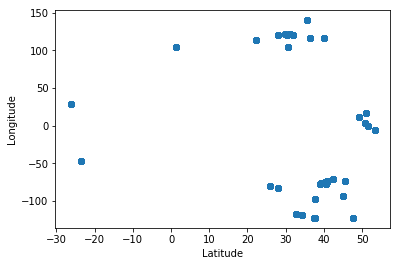

In [129]:
lat_data = copy_data["lat"]
lon_data = copy_data["lon"]

plt.scatter(lat_data, lon_data)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [132]:
data["ip_src"].unique()[10:20]

array(['54.192.49.181', '104.16.90.50', '128.112.136.10',
       '192.99.232.131', '128.112.92.1', '54.192.49.18', '128.112.92.50',
       '104.244.46.71', '72.21.91.70', '52.4.95.48'], dtype=object)

Look up some of these IPs. What do you think this plot is a map of?

Now, let's cluster them! Take a few minutes to play with different numbers of clusters. What should the clusters represent? See if you can produce a good clustering. What should the clusters represent?

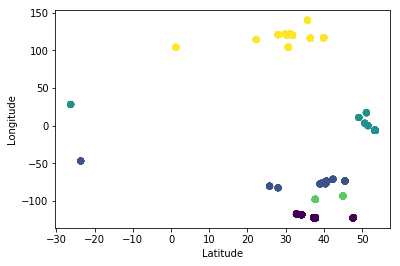

In [130]:
kmeans = KMeans(n_clusters=?)

kmeans_data = list(zip(lat_data, lon_data))
kmeans.fit(kmeans_data)
clusters = kmeans.predict(kmeans_data)

plt.scatter(lat_data, lon_data, c=clusters)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

## K-Means Goes Wrong

Now, we'll examine a case where clustering performs poorly, despite there being seemingly good positions for these clusters.

On the X-axis, we will graph the source IPs of our data.
On the Y-axis, we will graph the total # of bytes sent by each IP.

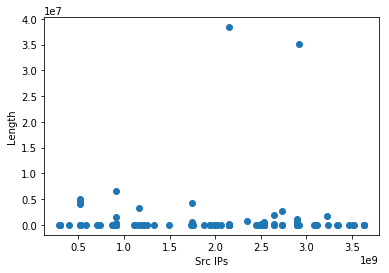

In [62]:
ip_src = data[data["ip_src_int"].notnull()]["ip_src_int"].unique()
ip_src.sort()
ip_src_lengths = data[data["ip_src_int"].notnull()].groupby("ip_src_int").sum()["length"]

plt.scatter(ip_src, ip_src_lengths)
plt.xlabel("Src IPs")
plt.ylabel("Length")
plt.show()

How many clusters should there be? Where should they be placed?

Text(0,0.5,'Lengths')

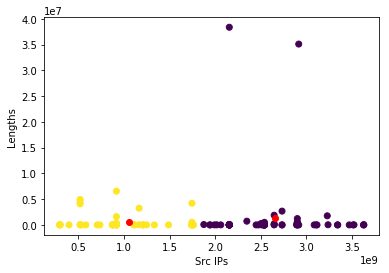

In [150]:
kmeans = KMeans(n_clusters=2)
kmeans_data = list(zip(ip_src, ip_src_lengths))
kmeans.fit(kmeans_data)
clusters = kmeans.predict(kmeans_data)

plt.scatter(ip_src, ip_src_lengths, c=clusters)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], color='red')
plt.xlabel("Src IPs")
plt.ylabel("Lengths")

K-Means has a hard time producing a good clustering of the data. Because there are so many senders with a short connection, K-Means prefers to choose centroids near the bottom of the graph to minimize the total error.

A simple modification to produce a better clustering would be to multiply all the lengths by a large constant. This way, the penalty of the outlying two points would be so great that K-means now prefers to choose a centroid near the two senders with large sending amounts.

In [ ]:
kmeans = KMeans(n_clusters=2)
kmeans_data = list(zip(ip_src, ip_src_lengths))
kmeans.fit(kmeans_data)
clusters = kmeans.predict(kmeans_data)

plt.scatter(ip_src, ip_src_lengths, c=clusters)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], color='red')
plt.xlabel("Src IPs")
plt.ylabel("Lengths")

## Conclusion

Unsupervised learning is a different paradigm in machine learning in which the learner must find structure in a dataset on her own without the benefit of pre-labeled data. This can be used in instances where labels are not available, but as we’ve seen in this lab, it can also be used to discover interesting patterns in data that you might not have known to look for ahead of time.

K-means clustering is a simple yet effective unsupervised machine learning algorithm for data clustering. It clusters data based on the Euclidean distance between data points.